# Adversarial AutoEncoder

Auto Encoder과 GAN 을 합친 모델이다.

인풋을 encoding 한 다음에, 이를 특정 distribution 에 mapping 해주도록 한다.

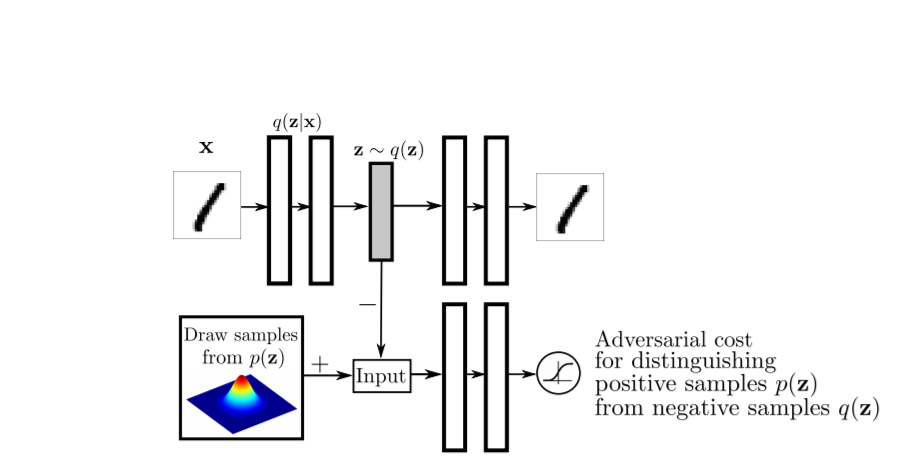

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [44]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def reform(mu, logvar):
  std = torch.exp(logvar / 2)
  z = torch.empty(mu.size(0), mu.size(1)).normal_().to(DEVICE)
  #z score 참고 값들 넘기면 됨.
  z = z * std + mu

  return z

class Encoder(nn.Module):
  def __init__(self, in_channels, height, width, latent_dim=10):
    super().__init__()

    self.layer = nn.Sequential(
        nn.Linear(in_channels * height * width, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
    )

    self.mu = nn.Linear(512, latent_dim)
    self.logvar = nn.Linear(512, latent_dim)

  def forward(self, x):
    out = self.layer(x.view(x.size(0),-1))

    mu = self.mu(out)
    logvar = self.logvar(out)

    z = reform(mu, logvar)

    return z

class Decoder(nn.Module):
  def __init__(self, in_channels, height, width, latent_dim=10):
    super().__init__()

    self.in_channels = in_channels
    self.height = height
    self.width = width

    self.layer = nn.Sequential(
        nn.Linear(latent_dim, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, in_channels * height * width),
        nn.Tanh(),
    )

  def forward(self, z):
    out = self.layer(z)
    out = out.view(-1, self.in_channels, self.height, self.width)

    return out


class Discriminator(nn.Module):
  
  def __init__(self, latent_dim=10):
    super().__init__()

    self.layer = nn.Sequential(
        nn.Linear(latent_dim, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(256, 1),
        nn.Sigmoid(),
    )

  def forward(self, z):
    out = self.layer(z)
    
    return out

In [3]:
def plot(d_loss, a_loss):
  clear_output()
  plt.figure(figsize = (20,5))
  plt.subplot(121)
  plt.title('discriminator_loss')
  plt.plot(d_loss)
  plt.subplot(122)
  plt.title('generator_loss')
  plt.plot(a_loss)
  plt.tight_layout()
  plt.show()


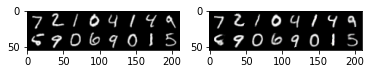

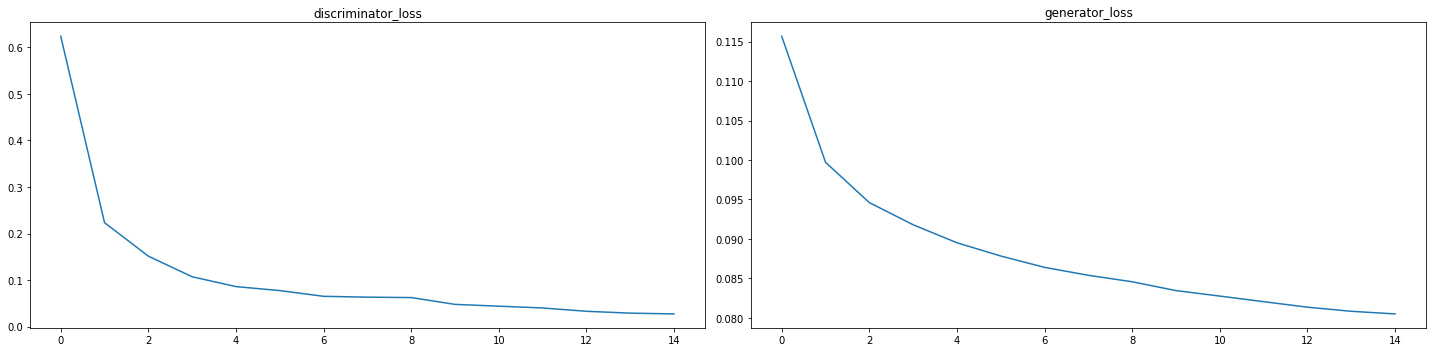

epoch 15
discriminator_loss : 0.02740478515625
generator_loss : 0.08050697296857834


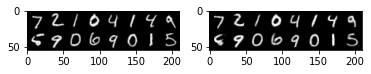

In [53]:
BATCH_SIZE = 16
LR = 0.001
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
train_transforms = transforms.Compose([
                                       transforms.Resize(24),
                                       transforms.Grayscale(3),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = torchvision.datasets.MNIST(root='./', train=True, transform=train_transforms, download=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./', train=False, transform=train_transforms, download=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

def train(epochs, train_dataloader, test_loader,latent_dim=10):
  encoder = Encoder(3,24,24,latent_dim)
  decoder = Decoder(3,24,24, latent_dim)
  discriminator = Discriminator(latent_dim)

  encoder.to(DEVICE)
  decoder.to(DEVICE)
  discriminator.to(DEVICE)

  d_loss = nn.BCELoss()
  a_loss = nn.L1Loss()

  d_optimizer = optim.Adam(discriminator.parameters(),lr=LR)
  a_optimizer = optim.Adam(list(encoder.parameters())+list(decoder.parameters()), lr=LR)

  d_losses = []
  g_losses = []
  for epoch in range(1, epochs+1):
    tmp_d_loss = 0.
    tmp_g_loss = 0.
    for data, _ in train_dataloader:
      data = data.float().to(DEVICE)

      a_optimizer.zero_grad()
      
      
      encoding = encoder(data)
      decoding = decoder(encoding)

      #train autoencoder
      g_loss = a_loss(data, decoding)
      g_loss.backward()
      a_optimizer.step()
      #train discriminator
      d_optimizer.zero_grad()
      z = torch.empty(encoding.size(0), encoding.size(1)).normal_().to(DEVICE)
      dis_loss = d_loss(discriminator(encoding.detach()), torch.zeros((data.size(0),1)).to(DEVICE)) + d_loss(discriminator(z), torch.ones((data.size(0),1)).to(DEVICE))

      dis_loss.backward()
      d_optimizer.step()
      
      tmp_g_loss += g_loss
      tmp_d_loss += dis_loss
    
    tmp_g_loss /= len(train_dataloader)
    tmp_d_loss /= len(train_dataloader)

    d_losses.append(tmp_d_loss)
    g_losses.append(tmp_g_loss)

    plot(d_losses, g_losses)
    print('epoch {0}'.format(epoch))
    print('discriminator_loss : {0}'.format(tmp_d_loss))
    print('generator_loss : {0}'.format(tmp_g_loss))

    for data, target in test_loader:
      data = data.float().to(DEVICE)

      with torch.no_grad():
        out = encoder(data)
        out = decoder(out)

        plt.subplot(121)
        plt.imshow(torchvision.utils.make_grid(data.to('cpu'), normalize=True).permute(1,2,0))
        plt.subplot(122)
        plt.imshow
        plt.imshow(torchvision.utils.make_grid(out.to('cpu'), normalize=True).permute(1,2,0))
        break

      
        

  
train(15, train_dataloader, test_dataloader)